In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
first_row_M = session.query(Measurement).first()
first_row_M.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x113d42dd8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [11]:
first_row_S = session.query(Station).first()
first_row_S.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x113677358>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'id': 1,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US'}

In [12]:
inspector = inspect(engine)
print(inspector.get_table_names())

inspect_cols_M = inspector.get_columns('measurement')
print("--Measurement:")
for c in inspect_cols_M:
    print(c['name'], c['type'])
    
inspect_cols_M = inspector.get_columns('station')
print("--Station:")
for c in inspect_cols_M:
    print(c['name'], c['type'])

['measurement', 'station']
--Measurement:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

                prcp
date                
2016-08-24  1.555000
2016-08-25  0.108000
2016-08-26  0.025000
2016-08-27  0.106667
2016-08-28  0.516667
2016-08-29  0.365000
2016-08-30  0.035000
2016-08-31  0.636000
2016-09-01  0.015000
2016-09-02  0.062500
             prcp
count  317.000000
mean     0.247885
std      0.333187
min      0.010000
25%      0.060000
50%      0.140000
75%      0.292500
max      2.380000


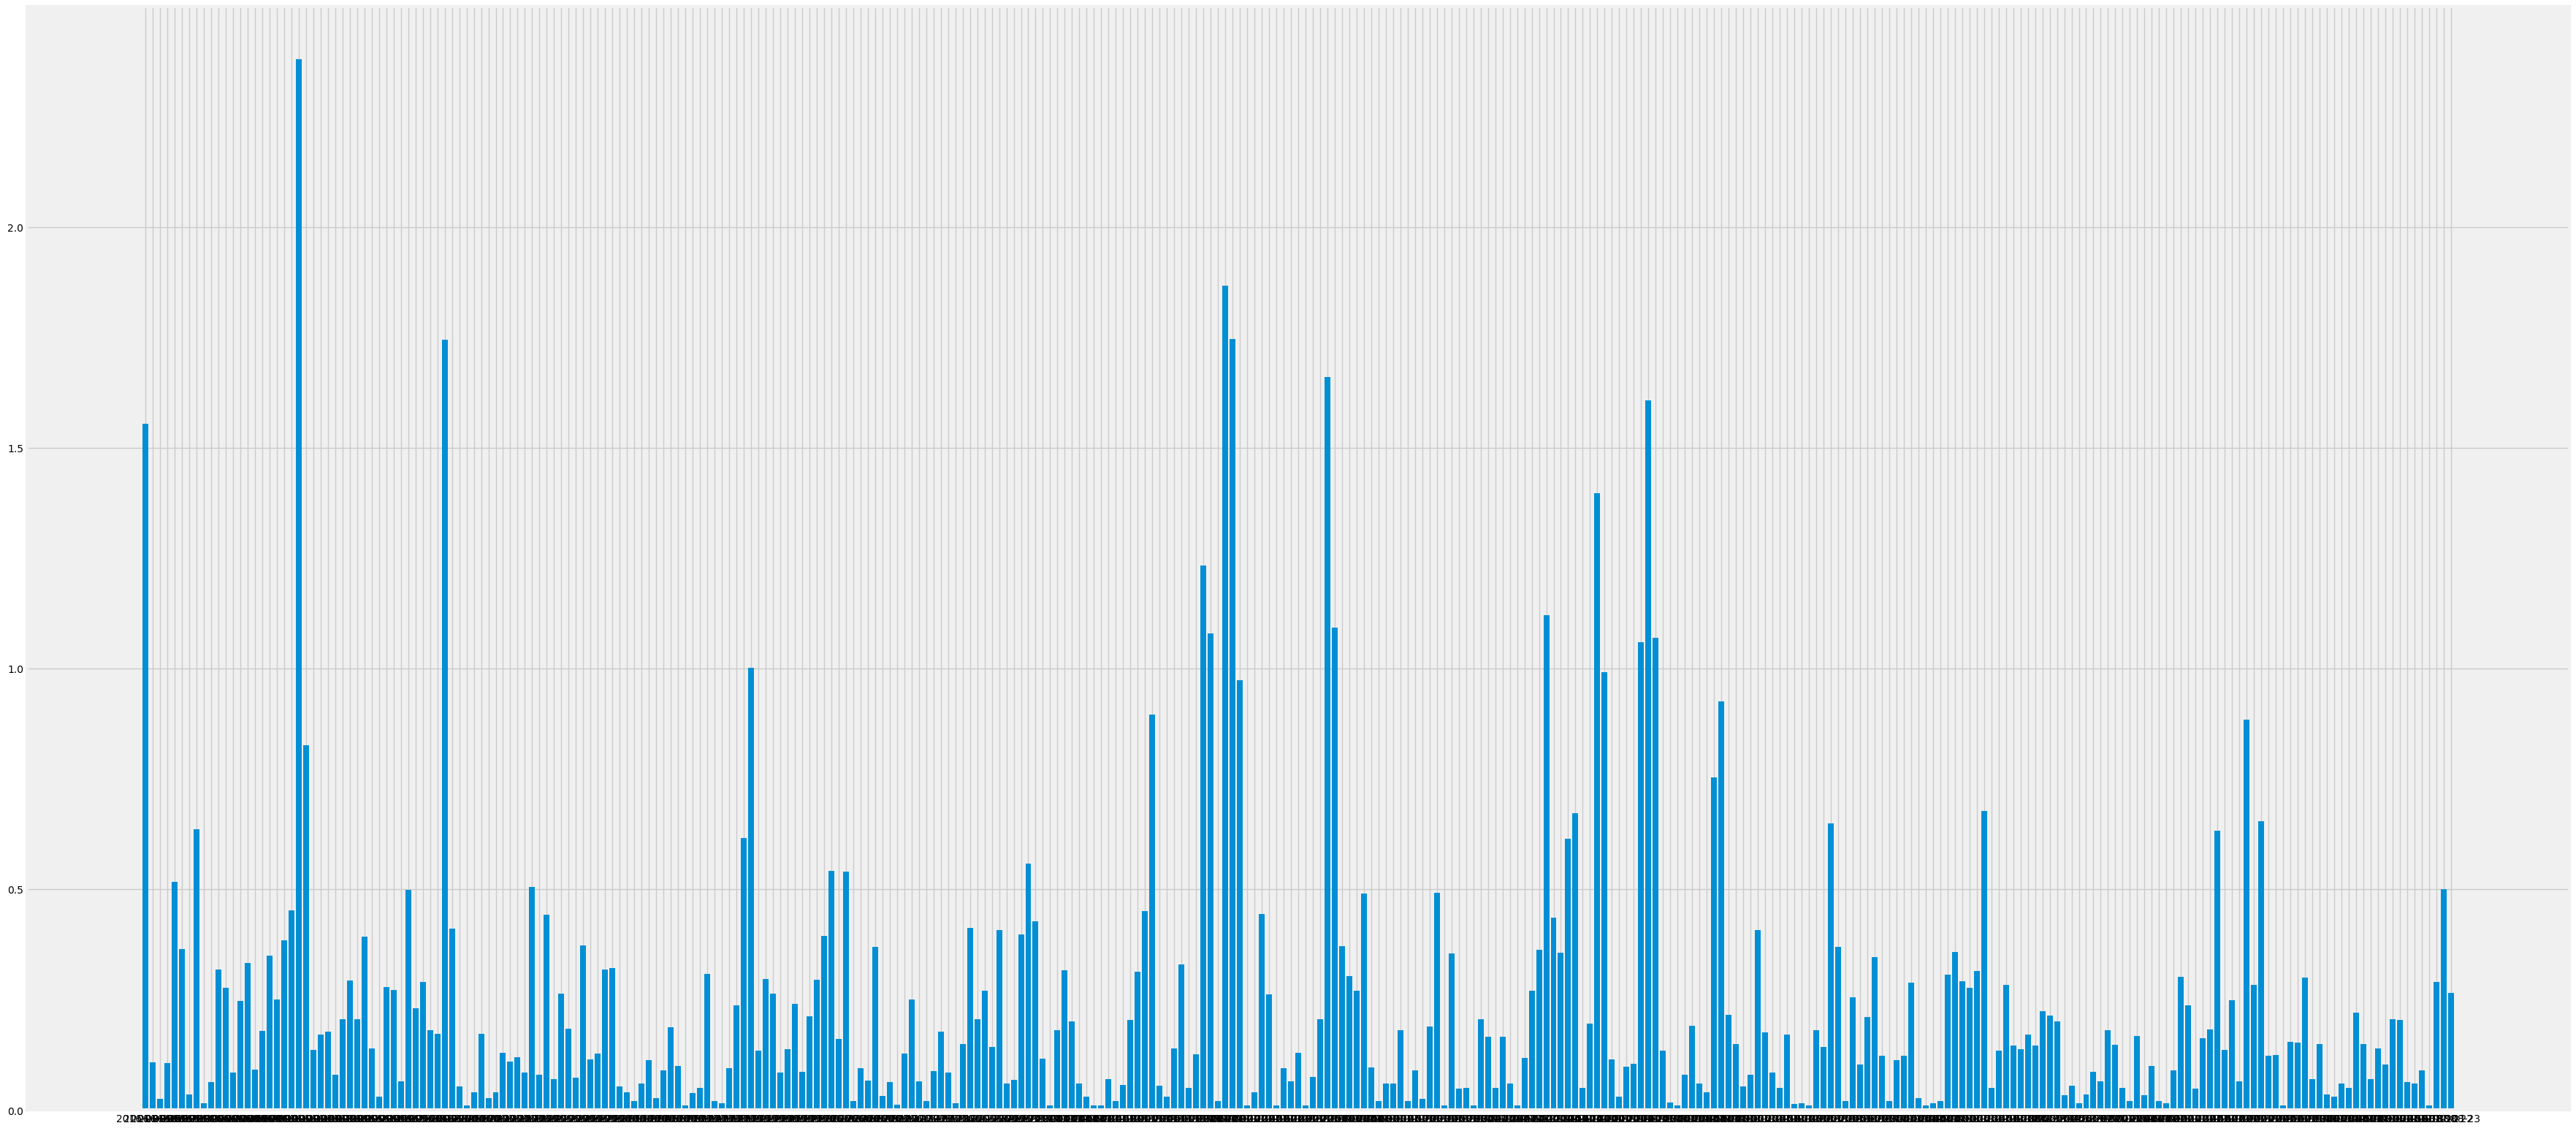

In [28]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date_dt = dt.datetime.strptime(latest_date, '%Y-%m-%d')

from dateutil.relativedelta import relativedelta

def yearsago(years, from_date=None):
    if from_date is None:
        from_date = datetime.now()
    return from_date - relativedelta(years=years)

year_ago_dt = yearsago(1, from_date=latest_date_dt)
year_ago = year_ago_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
year_ago_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > year_ago).\
    order_by(Measurement.date).all()
# if we want to remove NaN
year_ago_query_no_NaN = [i for i in year_ago_query if i[1]] 

# Save the query results as a Pandas DataFrame and set the index to the date column
year_ago_df = pd.DataFrame(year_ago_query_no_NaN)
year_ago_df = year_ago_df.groupby(['date']).mean()

# Sort the dataframe by date
year_ago_df.sort_values(by='date')
print(year_ago_df.head(10))
# grouped mean by day
print(year_ago_df.describe())

# Use Pandas Plotting with Matplotlib to plot the data
# !!!!TODO: need to tweak this for easier interpretation
plt.bar(year_ago_df.index.values.tolist(), year_ago_df.prcp.values.tolist(), linewidth=0.5)
plt.rcParams["figure.figsize"] = (40,20)
plt.show()

![precipitation](Images/precipitation.png)

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# not grouped mean values by day  
yg_df = pd.DataFrame(year_ago_query)
yg_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station).count()
print("Total number of stations: "+str(num_stations))
print("------------------------------")
comment = '''
--Station:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
'''

stations = session.query(Station).all()
for i in stations:
    print( "Station ID: " + str(i.id) + " | name: " + i.name)

Total number of stations: 9
------------------------------
Station ID: 1 | name: WAIKIKI 717.2, HI US
Station ID: 2 | name: KANEOHE 838.1, HI US
Station ID: 3 | name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Station ID: 4 | name: PEARL CITY, HI US
Station ID: 5 | name: UPPER WAHIAWA 874.3, HI US
Station ID: 6 | name: WAIMANALO EXPERIMENTAL FARM, HI US
Station ID: 7 | name: WAIHEE 837.5, HI US
Station ID: 8 | name: HONOLULU OBSERVATORY 702.2, HI US
Station ID: 9 | name: MANOA LYON ARBO 785.2, HI US


In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Station.id, Station.name, Station.station, func.count(
    Measurement.station)).\
    filter(Measurement.station == Station.station).group_by(Station.name).statement

active_stations_df = pd.read_sql(active_stations, engine)
active_stations_df = active_stations_df.sort_values('count_1', ascending=False)
active_stations_df = active_stations_df.reset_index()
del active_stations_df['index']
active_stations_df = \
    active_stations_df.rename({'name': 'Station Name', 'count_1': 'Number of Activities'}, axis=1)
active_stations_df

,id,Station Name,station,Number of Activities
0,7,"WAIHEE 837.5, HI US",USC00519281,2772
1,1,"WAIKIKI 717.2, HI US",USC00519397,2724
2,2,"KANEOHE 838.1, HI US",USC00513117,2709
3,6,"WAIMANALO EXPERIMENTAL FARM, HI US",USC00519523,2669
4,9,"MANOA LYON ARBO 785.2, HI US",USC00516128,2612
5,3,"KUALOA RANCH HEADQUARTERS 886.9, HI US",USC00514830,2202
6,8,"HONOLULU OBSERVATORY 702.2, HI US",USC00511918,1979
7,4,"PEARL CITY, HI US",USC00517948,1372
8,5,"UPPER WAHIAWA 874.3, HI US",USC00518838,511


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temperatures = session.query(Station.name\
                             ,func.min(Measurement.tobs)\
                             ,func.max(Measurement.tobs)\
                             ,func.avg(Measurement.tobs))\
                            .filter(Measurement.station == Station.station)\
                            .filter(Station.station == 'USC00519281').statement

temperatures_df = pd.read_sql(temperatures, engine)
temperatures_df = temperatures_df.rename({'name':'Station Name'\
                                          , 'min_1':'Min Temp'\
                                          , 'max_1':'Max Temp'\
                                          , 'avg_1':'Avg Temp'}, axis=1)
temperatures_df.set_index('Station Name')

,Min Temp,Max Temp,Avg Temp
Station Name,,,
"WAIHEE 837.5, HI US",54.0,85.0,71.663781


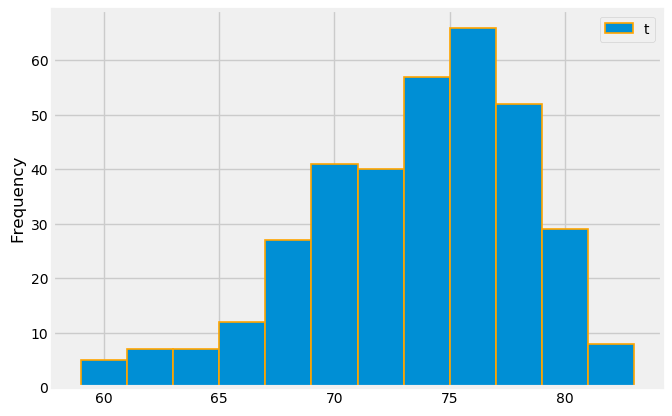

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

latest_date_for_station, = session.query(Measurement.date)\
                        .filter(Station.station == 'USC00519281')\
                        .order_by(Measurement.date.desc()).first()
latest_date_for_station_dt = dt.datetime.strptime(latest_date_for_station, '%Y-%m-%d')

year_ago_date_for_station = yearsago(1, from_date=latest_date_for_station_dt)

#print(latest_date_for_station)
#print(year_ago_date_for_station)

station_observations = session.query(Station.name\
                                     , Station.station\
                                     ,Measurement.tobs\
                                     , Measurement.date)\
                                    .filter(Measurement.station == Station.station)\
                                    .filter(Station.station == 'USC00519281')\
                                    .filter(Measurement.date > year_ago_date_for_station).all()
x_data = [i[2] for i in station_observations]
num_bins=12
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(x_data, num_bins, edgecolor='orange', linewidth=1.2)
plt.ylabel("Frequency")
plt.legend("tobs")
plt.show()

![precipitation](Images/station-histogram.png)

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [21]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [22]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [24]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [25]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [26]:
# Plot the daily normals as an area plot with `stacked=False`
